In [306]:
# Imports
from ypstruct import structure
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.spatial.distance import pdist, squareform
import re

In [307]:
def read_TTP_instance_data(file_path):
    nb_items = int(file_path.split("-")[1].strip("n").split(".txt")[0])
    nb_cities = int(re.sub("\D", "", file_path.split("-")[0].split("/")[2]))
    # Read node coordinates from the file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Initialize variables
    node_coordinates = []
    item_values = []
    item_weights= []
    in_node_section = False
    in_item_section = False
    item_to_city_mapping_dict = {}
    v_min = None
    v_max = None
    max_capacity = None
    renting_ratio = None

    for i in range(nb_cities):
        item_to_city_mapping_dict[i] = []

    # Extract node coordinates and item data
    for line in lines:
        if line.startswith("CAPACITY OF KNAPSACK"):
            max_capacity = int(line.strip().split()[3])
            continue
        elif line.startswith("MIN SPEED"):
            v_min = float(line.strip().split()[2])
        elif line.startswith("MAX SPEED"):
            v_max = float(line.strip().split()[2])
        elif line.startswith("RENTING RATIO"):
            renting_ratio = float(line.strip().split()[2])
        elif line.startswith('NODE_COORD_SECTION'):
            in_node_section = True
            in_item_section = False
            continue
        elif line.startswith('ITEMS SECTION'):
            in_node_section = False
            in_item_section = True
            continue
        elif line.startswith('EOF'):
            break
        
        if in_node_section:
            _, x, y = map(int, line.strip().split())
            node_coordinates.append((x, y))
        elif in_item_section:
            item_id, profit, weight, node_number = map(int, line.strip().split())
            item_to_city_mapping_dict[node_number - 1].append(item_id-1) # re-index to 0
            item_values.append(profit)
            item_weights.append(weight)
    
    return {"nb_cities": nb_cities,
            "nb_items": nb_items,
            "Q": max_capacity, 
            "v_min": v_min, 
            "v_max": v_max, 
            "R": renting_ratio, 
            "pairwise_distances": pdist(node_coordinates), 
            "item_to_city_mapping":item_to_city_mapping_dict,
            "item_weights": np.array(item_weights),
            "item_values": np.array(item_values)
            }

#### Replicating the example evaluation of a candidate solution found in as found https://link.springer.com/chapter/10.1007/978-3-319-54157-0_4

Setting up the problem example

In [308]:
item_values = np.array([30, 34, 40, 25])
item_weights = np.array([25, 30, 40, 21])

item_to_city_mapping_dict = {0:[0], 1:[1], 2:[2], 3:[3]}
distance_matrix = np.array(
    [
    [0, 4, 9, 3],
    [4, 0, 5, 5],
    [9, 5, 0, 8],
    [3, 5, 8, 0]
    ]
).astype(float)

vmax = 1.0
vmin = 0.1
Q = 80

Cost function for the knapsack, as given by:
$$
  \sum^m_{j = 1} z_j * b_j
$$
where $z_j$ is the a binary vector where each index corresponds to an item and is 0 if the item is not picked and 1 if it is and $b_j$ is the values vector.

In [309]:
def knapsack_cost(candidate_solution, item_values):
    return np.sum(candidate_solution.packing_plan * item_values)

Cost function for the tour, taking into account velocity, as given by:
$$
    f(\pi, z) = \frac{d_{\pi_1, \pi_{n}} * R}{v(w(\pi_{n}))} + \sum^{n-1}_{i = 1} \frac{d_{\pi_i, \pi_{i+1}} * R}{v(w(\pi_{i}))}
$$ 
where 
$$
    w(\pi_i) = \sum^{i}_{k=1}\sum^{m}_{j=1} z_j * b_j * a_{j, \pi_i}
$$ 

and 
$$
    v(q) = v_{max} - \frac{q}{Q} * (v_{max} - v_{min})
$$ 

where $d_{\pi_i, \pi_{i+1}}$ is the distance between city $i$ and $i+1$, obtained from the distance matrix $d$ and $a$ is the item mapping matrix and R is the renting ratio

In [310]:
def tour_cost(candidate_solution, distance_matrix, item_to_city_mapping_dict, item_weights, vmax, vmin, Q, renting_ratio):
    tour = candidate_solution.tour
    
    # calculate the weight picked up at each city
    weight_at_city_i = []
    for city in tour:
        # Create a row filled with zeros for the selected item
        item_city_row = np.zeros(len(item_weights), dtype=int)
        items_in_city = item_to_city_mapping_dict[city]
        # Fill in the row based on the item to city mapping for the selected item
        item_city_row[items_in_city] = 1

        weight_at_city_i.append(sum(item_city_row * candidate_solution.packing_plan * item_weights))
    # calculate the total weight that the thief has when leaving each city using the cumulative sum 
    weight_at_city_i = np.array(np.cumsum(weight_at_city_i))
    # calculate the velocity of the thief when leaving each city
    velocity_at_city_i = vmax - weight_at_city_i / Q * (vmax - vmin)
    # retrieve the distance between the cities 
    distance_between_cities = []


    for i in range(0, len(tour)-1):

        distance_between_cities.append(distance_matrix[tour[i]][tour[i+1]])
    distance_between_cities.append(distance_matrix[tour[0]][tour[-1]])
    distance_matrix = np.array(distance_between_cities)
    
    # return the total completion time
    return np.sum(distance_between_cities / velocity_at_city_i) * renting_ratio

Setting up the candidate solution and evaluating it using the previously defined function

In [311]:
def evaluate_candidate_solution_cost(candidate_solution, distance_matrix, item_to_city_mapping_dict, item_weights, item_values, vmax, vmin, Q, renting_ratio):
    candidate_solution.tour_cost = tour_cost(candidate_solution, distance_matrix, item_to_city_mapping_dict, item_weights, vmax, vmin, Q, renting_ratio)
    candidate_solution.packing_plan_cost = knapsack_cost(candidate_solution, item_values)
    return candidate_solution

In [312]:
candidate_solution = structure()

candidate_solution.tour = np.array([0, 1, 2, 3]) # 4 cities
candidate_solution.packing_plan = np.array([0, 0, 0, 0]) # 4 items
candidate_solution.tour_cost = tour_cost(candidate_solution, distance_matrix, item_to_city_mapping_dict, item_weights, vmax, vmin, Q, 1)
candidate_solution.packing_plan_cost = knapsack_cost(candidate_solution, item_values)
print(candidate_solution.tour_cost)
print(candidate_solution.packing_plan_cost)


20.0
0


In [313]:
evaluate_candidate_solution_cost(candidate_solution, distance_matrix, item_to_city_mapping_dict, item_weights, item_values, vmax, vmin, Q, 1)

struct({'tour': array([0, 1, 2, 3]), 'packing_plan': array([0, 0, 0, 0]), 'tour_cost': 20.0, 'packing_plan_cost': 0})

In [314]:
def random_tour(distance_matrix):
    return np.array(random.sample(list(range(distance_matrix.shape[0])), k = distance_matrix.shape[0]))

In [315]:
def find_min_indices_in_row(matrix, row_index):
    row = matrix[row_index, :]
    min_value = np.min(row)
    min_indices = np.where(row == min_value)

    if len(min_indices[0]) == 1:
        # If there's a single minimum value, return only its index in the specified row
        return [min_indices[0][0]]
    else:
        # If there are duplicates, return all occurrences within the specified row
        return [col_index for col_index in min_indices[0]]


In [316]:
def nearest_neighbour(distance_matrix):
    dist_matrix = distance_matrix.copy()
    num_cities = dist_matrix.shape[0]
    start_city = random.sample(list(range(num_cities)), k = 1)
    dist_matrix[:, start_city[0]] = np.inf

    for _ in range(1, num_cities):
        current_city = start_city[-1]
        next_city = random.sample(find_min_indices_in_row(dist_matrix, current_city), k = 1)[0]
        start_city.append(next_city)
        dist_matrix[:, next_city] = np.inf
    
    return np.array(start_city)

        

In [317]:
def tour_length(tour, distance_matrix: list[list]) -> float:
    
    # cost of going from last city in the chromosme back to the starting chromosome
    return_to_start_length = distance_matrix[len(distance_matrix)-1][tour[0]]
    # calculate the cost for the rest of the tour
    travel_length = 0
    for i in range(0, len(distance_matrix)-1, 1):
        travel_length += distance_matrix[tour[i]][tour[i+1]]

    return travel_length + return_to_start_length


In [318]:
def nearest_neighbour_2opt(distance_matrix):
    tour = nearest_neighbour(distance_matrix=distance_matrix)
    number_of_cities = distance_matrix.shape[0]
    max_2opt_moves = (number_of_cities) * (number_of_cities - 1) / 2
    made_moves = []
    length = tour_length(tour, distance_matrix)
    better = False
    i = 0 

    while not better and i < max_2opt_moves:
        i += 1
        idx = range(len(tour))
        made_move = False
        i1, i2 = (None, None)
        while not made_move:
            i1_test, i2_test = random.sample(idx, 2)
            if (i1_test, i2_test) in made_moves or (i2_test, i1_test) in made_moves:
                continue
            else:
                i1, i2 = i1_test, i2_test
                made_move = True
        made_moves.append((i1, i2))
        made_moves.append((i2, i1))
        new_tour = tour.copy()
        new_tour[i1], new_tour[i2] = new_tour[i2], new_tour[i1]
        if tour_length(new_tour, distance_matrix) < length:
            better = True
            tour = new_tour
    return np.array(tour)


   

In [319]:
def pack_one(init_pop, item_to_city_mapping_dict):
    number_of_items = len(item_to_city_mapping_dict)
    for candidate_solution in init_pop:
        packing_plan = np.zeros(number_of_items)
        chosen_item = random.sample(list(range(number_of_items)), k = 1)
        packing_plan[chosen_item] = 1
        candidate_solution.packing_plan = np.array(packing_plan)
    return init_pop

In [320]:
def pack_random(init_pop, item_to_city_mapping_dict):
    number_of_items = len(item_to_city_mapping_dict)
    for candidate_solution in init_pop:
        packing_plan = np.array([random.choice(list(range(2))) for _ in range(number_of_items)])
        candidate_solution.packing_plan = np.array(packing_plan)
    return init_pop

In [321]:
value_to_weight_ratio = item_values / item_weights
value_to_weight_ratio_dict = {}
for i in range(len(value_to_weight_ratio)):
    value_to_weight_ratio_dict[i] = value_to_weight_ratio[i]
sorted_value_to_weight_ratio_dict = dict(sorted(value_to_weight_ratio_dict.items(), key=lambda x:x[1], reverse = True))
sorted_value_to_weight_ratio_dict

{0: 1.2, 3: 1.1904761904761905, 1: 1.1333333333333333, 2: 1.0}

In [322]:
def pack_optimal(init_pop, item_to_city_mapping_dict, Q, value_to_weight_ratio_dict, item_weights):

    number_of_items = len(item_weights)
    
    sorted_value_to_weight_ratio_dict = dict(sorted(value_to_weight_ratio_dict.items(), key=lambda x:x[1], reverse = True))

    for candidate_solution in init_pop:
        Q_prime = np.random.randint(low = 0, high = Q, size = 1)
        packing_plan = np.zeros(number_of_items)
        weight  = 0
        for i in range(number_of_items):
            if weight + item_weights[list(sorted_value_to_weight_ratio_dict.keys())[i]] < Q_prime:

                packing_plan[list(sorted_value_to_weight_ratio_dict.keys())[i]] = 1
                weight += item_weights[list(sorted_value_to_weight_ratio_dict.keys())[i]]
        candidate_solution.packing_plan = np.array(packing_plan)
    return init_pop

In [323]:
def generate_initial_population(pop_size, distance_matrix, item_to_city_mapping_dict, tour_init_method, pack_init_method, Q = None, value_to_weight_ratio_dict = None, item_weights = None): # Jack

    init_pop = []

    if tour_init_method == "random":
        for _ in range(pop_size):
            candidate_solution = structure()
            candidate_solution.tour = random_tour(distance_matrix=distance_matrix)
            init_pop.append(candidate_solution)
    elif tour_init_method == "nearest_neighbour":
        for _ in range(pop_size):
            candidate_solution = structure()
            candidate_solution.tour = nearest_neighbour(distance_matrix=distance_matrix)
            init_pop.append(candidate_solution)
    elif tour_init_method == "2opt_nearest_neighbour":
        for _ in range(pop_size):
            candidate_solution = structure()
            candidate_solution.tour = nearest_neighbour_2opt(distance_matrix=distance_matrix)
            init_pop.append(candidate_solution)

    if pack_init_method == "random":
        pack_random(init_pop, item_to_city_mapping_dict)
    elif pack_init_method == "pack_one":
        pack_one(init_pop, item_to_city_mapping_dict)
    elif pack_init_method == "pack_optimal":
        pack_optimal(init_pop, item_to_city_mapping_dict, Q, value_to_weight_ratio_dict, item_weights)

    return init_pop

In [324]:
init_pop = generate_initial_population(50, 
                                       distance_matrix, 
                                       item_to_city_mapping_dict, 
                                       "random", 
                                       "pack_optimal", 
                                       80, 
                                       value_to_weight_ratio_dict, 
                                       item_weights)

In [325]:
evaled_pop = [evaluate_candidate_solution_cost(i, distance_matrix, item_to_city_mapping_dict, item_weights, item_values, vmax, vmin, Q, 1) for i in init_pop]


In [326]:
for i in init_pop:
    if i.tour_cost < 25 and i.tour_cost > 21:
        print(i)

struct({'tour': array([0, 3, 1, 2]), 'packing_plan': array([0., 0., 0., 0.]), 'tour_cost': 22.0, 'packing_plan_cost': 0.0})
struct({'tour': array([0, 3, 1, 2]), 'packing_plan': array([0., 0., 0., 0.]), 'tour_cost': 22.0, 'packing_plan_cost': 0.0})
struct({'tour': array([1, 2, 0, 3]), 'packing_plan': array([0., 0., 0., 0.]), 'tour_cost': 22.0, 'packing_plan_cost': 0.0})
struct({'tour': array([3, 1, 2, 0]), 'packing_plan': array([0., 0., 0., 0.]), 'tour_cost': 22.0, 'packing_plan_cost': 0.0})
struct({'tour': array([2, 1, 3, 0]), 'packing_plan': array([0., 0., 0., 0.]), 'tour_cost': 22.0, 'packing_plan_cost': 0.0})
struct({'tour': array([2, 1, 3, 0]), 'packing_plan': array([0., 0., 0., 0.]), 'tour_cost': 22.0, 'packing_plan_cost': 0.0})
struct({'tour': array([2, 1, 0, 3]), 'packing_plan': array([1., 0., 0., 0.]), 'tour_cost': 24.304347826086957, 'packing_plan_cost': 30.0})
struct({'tour': array([3, 1, 2, 0]), 'packing_plan': array([1., 0., 0., 0.]), 'tour_cost': 23.17391304347826, 'packin

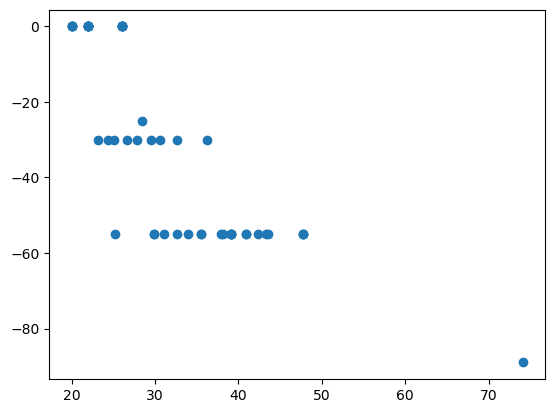

In [327]:
plt.scatter([sol.tour_cost for sol in evaled_pop], [-1 * sol.packing_plan_cost for sol in evaled_pop])

In [328]:
a280_n1395 = read_TTP_instance_data("../data/a280-n1395.txt")

In [329]:
a280_n1395_dist_mat = squareform(a280_n1395["pairwise_distances"])

In [330]:
a280_n1395_value_to_weight_ratio = a280_n1395["item_values"] / a280_n1395["item_weights"]
a280_n1395_value_to_weight_ratio_dict = {}
for i in range(len(a280_n1395_value_to_weight_ratio)):
    a280_n1395_value_to_weight_ratio_dict[i] = a280_n1395_value_to_weight_ratio[i]
a280_n1395_sorted_value_to_weight_ratio_dict = dict(sorted(a280_n1395_value_to_weight_ratio_dict.items(), key=lambda x:x[1], reverse = True))

In [332]:
init_pop = generate_initial_population(50, 
                                       a280_n1395_dist_mat, 
                                       a280_n1395["item_to_city_mapping"], 
                                       "random", 
                                       "pack_optimal", 
                                       a280_n1395["Q"], 
                                       a280_n1395_value_to_weight_ratio_dict,
                                       a280_n1395["item_weights"])

In [333]:
evaled_pop = [
    evaluate_candidate_solution_cost(candidate_solution,
                                     a280_n1395_dist_mat,
                                     a280_n1395["item_to_city_mapping"],
                                     a280_n1395["item_weights"],
                                     a280_n1395["item_values"],
                                     a280_n1395["v_max"],
                                     a280_n1395["v_min"],
                                     a280_n1395["Q"],
                                     a280_n1395["R"])
    for candidate_solution in init_pop
]

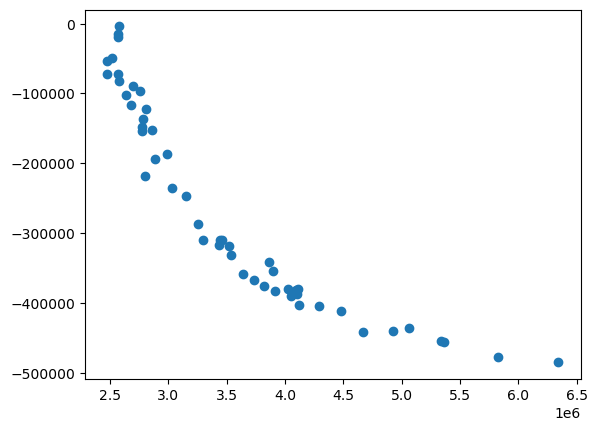

In [334]:
plt.scatter([sol.tour_cost for sol in evaled_pop], [-1 * sol.packing_plan_cost for sol in evaled_pop])